In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.7 MB/s eta 0:00:00


In [ ]:
import os
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import KFold
from tqdm.auto import tqdm
import optuna

In [ ]:
def seed_everything(seed=31):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

In [ ]:
light_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구 보안등 정보.csv', encoding='cp949')[['설치개수', '소재지지번주소']]
light_df = light_df.rename(columns={'설치개수': '보안등 설치개수'})

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

child_area_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949').drop_duplicates()[['소재지지번주소', 'CCTV설치대수']]
# 어린이 보호구역을 의미
child_area_df['보호구역'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

parking_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구 주차장 정보.csv', encoding='cp949')[['소재지지번주소', '급지구분']]
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)

cctv_df = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/external_open/대구 CCTV 정보.csv', encoding='cp949')[['소재지지번주소', '단속구분']]
cctv_df = pd.get_dummies(cctv_df, columns=['단속구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동', '번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df.drop(columns=['소재지지번주소', '번지'])

cctv_df = cctv_df.groupby(['도시', '구', '동']).sum().reset_index()
cctv_df.reset_index(inplace=True, drop=True)

In [ ]:
train_org = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/train.csv')
test_org = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/교통사고/open/open/sample_submission.csv')


In [ ]:
train_df = train_org.copy()
test_df = test_org.copy()

In [ ]:
accident_counts = train_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옴
train_df['사고발생횟수'] = train_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
# '시군구'별 사고 횟수를 test_df 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옴
test_df['사고발생횟수'] = test_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])
test_df = test_df.drop(columns=['시군구'])

In [ ]:
display(train_df)
display(test_df)

,ID,사고일시,요일,기상상태,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,도시,구,동,사고발생횟수
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,대구광역시,중구,대신동,131
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,대구광역시,달서구,감삼동,678
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3,대구광역시,수성구,두산동,604
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5,대구광역시,북구,복현동,426
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3,대구광역시,동구,신암동,825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19,금요일,맑음,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,승용,여,52세,상해없음,이륜,남,28세,경상,0,0,1,0,3,대구광역시,수성구,수성동3가,104
39605,ACCIDENT_39605,2021-12-31 19,금요일,맑음,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,승용,여,60세,상해없음,승용,남,52세,경상,0,0,1,0,3,대구광역시,달서구,상인동,1143
39606,ACCIDENT_39606,2021-12-31 21,금요일,맑음,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,승용,남,60세,중상,승용,남,73세,중상,0,2,0,0,10,대구광역시,달서구,월성동,618
39607,ACCIDENT_39607,2021-12-31 22,금요일,맑음,기타 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,40세,상해없음,승용,여,57세,경상,0,0,1,0,3,대구광역시,달서구,장동,125


,ID,사고일시,요일,기상상태,도로형태,노면상태,사고유형,도시,구,동,사고발생횟수
0,ACCIDENT_39609,2022-01-01 01,토요일,맑음,교차로 - 교차로안,건조,차대사람,대구광역시,수성구,상동,338
1,ACCIDENT_39610,2022-01-01 01,토요일,맑음,단일로 - 기타,건조,차대사람,대구광역시,수성구,지산동,492
2,ACCIDENT_39611,2022-01-01 04,토요일,맑음,교차로 - 교차로안,건조,차대차,대구광역시,수성구,수성동2가,147
3,ACCIDENT_39612,2022-01-01 04,토요일,맑음,단일로 - 기타,건조,차대차,대구광역시,수성구,신매동,372
4,ACCIDENT_39613,2022-01-01 06,토요일,맑음,교차로 - 교차로안,건조,차대차,대구광역시,달서구,감삼동,678
...,...,...,...,...,...,...,...,...,...,...,...
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,단일로 - 터널,건조,차대차,대구광역시,남구,대명동,1749
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,단일로 - 기타,건조,차대차,대구광역시,수성구,시지동,167
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,단일로 - 기타,건조,차대차,대구광역시,수성구,연호동,107
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,교차로 - 교차로부근,건조,차대차,대구광역시,수성구,범물동,239


In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

In [ ]:
# train_df와 test_df에, light_df와 child_area_df, parking_df를 merge하세요.
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])
train_df = pd.merge(train_df, cctv_df, how='left', on=['도시', '구', '동'])

test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, cctv_df, how='left', on=['도시', '구', '동'])

In [ ]:
test_x = test_df.drop(columns=['ID']).copy()
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()

In [ ]:
train_x.isna().sum()

사고일시            0
요일              0
기상상태            0
노면상태            0
사고유형            0
도시              0
구               0
동               0
사고발생횟수          0
도로형태1           0
도로형태2           0
보안등 설치개수     9513
CCTV설치대수    18426
보호구역        18426
급지구분_1       6543
급지구분_2       6543
급지구분_3       6543
단속구분_1       1576
단속구분_2       1576
단속구분_4       1576
단속구분_99      1576
dtype: int64

In [ ]:
test_x.isna().sum()

사고일시           0
요일             0
기상상태           0
노면상태           0
사고유형           0
도시             0
구              0
동              0
사고발생횟수         0
도로형태1          0
도로형태2          0
보안등 설치개수    2771
CCTV설치대수    4961
보호구역        4961
급지구분_1      1928
급지구분_2      1928
급지구분_3      1928
단속구분_1       455
단속구분_2       455
단속구분_4       455
단속구분_99      455
dtype: int64

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# IterativeImputer 모델 생성
imputer = IterativeImputer(max_iter=10)

# '보안등 설치개수','CCTV설치대수','보호구역', '급지구분_1', '급지구분_2', '급지구분_3','단속구분_1','단속구분_2','단속구분_4','단속구분_99' 열을 포함한 열들 선택
selected_columns = ['보안등 설치개수', 'CCTV설치대수', '보호구역', '급지구분_1', '급지구분_2', '급지구분_3',
                    '단속구분_1','단속구분_2','단속구분_4','단속구분_99']
data_for_imputation = train_x[selected_columns]

# IterativeImputer를 사용하여 결측치 채우기
imputed_data = imputer.fit_transform(data_for_imputation)

# 결과를 기존 데이터프레임에 적용
train_x[selected_columns] = imputed_data

# train 데이터프레임에 결측치가 없는지 확인
train_x.isna().sum()


사고일시        0
요일          0
기상상태        0
노면상태        0
사고유형        0
도시          0
구           0
동           0
사고발생횟수      0
도로형태1       0
도로형태2       0
보안등 설치개수    0
CCTV설치대수    0
보호구역        0
급지구분_1      0
급지구분_2      0
급지구분_3      0
단속구분_1      0
단속구분_2      0
단속구분_4      0
단속구분_99     0
dtype: int64

In [ ]:
# '보안등 설치개수','CCTV설치대수','보호구역', '급지구분_1', '급지구분_2', '급지구분_3','단속구분_1','단속구분_2','단속구분_4','단속구분_99' 열을 포함한 열들 선택
selected_columns = ['보안등 설치개수', 'CCTV설치대수', '보호구역', '급지구분_1', '급지구분_2', '급지구분_3',
                    '단속구분_1','단속구분_2','단속구분_4','단속구분_99']
data_for_imputation = test_x[selected_columns]

# IterativeImputer를 사용하여 결측치 채우기
imputed_data = imputer.transform(data_for_imputation)

# 결과를 기존 데이터프레임에 적용
test_x[selected_columns] = imputed_data

# test 데이터프레임에 결측치가 없는지 확인
test_x.isna().sum()

사고일시        0
요일          0
기상상태        0
노면상태        0
사고유형        0
도시          0
구           0
동           0
사고발생횟수      0
도로형태1       0
도로형태2       0
보안등 설치개수    0
CCTV설치대수    0
보호구역        0
급지구분_1      0
급지구분_2      0
급지구분_3      0
단속구분_1      0
단속구분_2      0
단속구분_4      0
단속구분_99     0
dtype: int64

In [ ]:
# '사고일시' 열을 datetime 형식으로 변환
train_x['사고일시'] = pd.to_datetime(train_x['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
train_x['year'] = train_x['사고일시'].dt.year
train_x['month'] = train_x['사고일시'].dt.month
train_x['day'] = train_x['사고일시'].dt.day
train_x['hour'] = train_x['사고일시'].dt.hour
train_x['day_of_week'] = train_x['사고일시'].dt.dayofweek

In [ ]:
# '사고일시' 열을 datetime 형식으로 변환
test_x['사고일시'] = pd.to_datetime(test_x['사고일시'])

# datetime에서 year, month, day, hour 추출하여 새로운 열 생성
test_x['year'] = test_x['사고일시'].dt.year
test_x['month'] = test_x['사고일시'].dt.month
test_x['day'] = test_x['사고일시'].dt.day
test_x['hour'] = test_x['사고일시'].dt.hour
test_x['day_of_week'] = test_x['사고일시'].dt.dayofweek

In [ ]:
holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']
# 공휴일 변수생성
train_x['holiday'] = np.where((train_x.day_of_week >= 5) | (train_x.사고일시.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)
test_x['holiday'] = np.where((test_x.day_of_week >= 5) | (test_x.사고일시.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

In [ ]:
# '사고일시' 열 삭제
train_x.drop(columns=['사고일시'], inplace=True)
# '사고일시' 열 삭제
test_x.drop(columns=['사고일시'], inplace=True)

In [ ]:
# 계절 변수 생성
def group_season(df):
    df.loc[(df['month'] == 3) | (df['month'] == 4) | (df['month'] == 5), 'season'] = '봄'
    df.loc[(df['month'] == 6) | (df['month'] == 7) | (df['month'] == 8), 'season'] = '여름'
    df.loc[(df['month'] == 9) | (df['month'] == 10) | (df['month'] == 11), 'season'] = '가을'
    df.loc[(df['month'] == 12) | (df['month'] == 1) | (df['month'] == 2), 'season'] = '겨울'
    return df['season']
train_x['season'] = group_season(train_x)
test_x['season'] = group_season(test_x)

In [ ]:
# train_x와 train_y를 합침
train_data = pd.concat([train_x, train_y], axis=1)

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

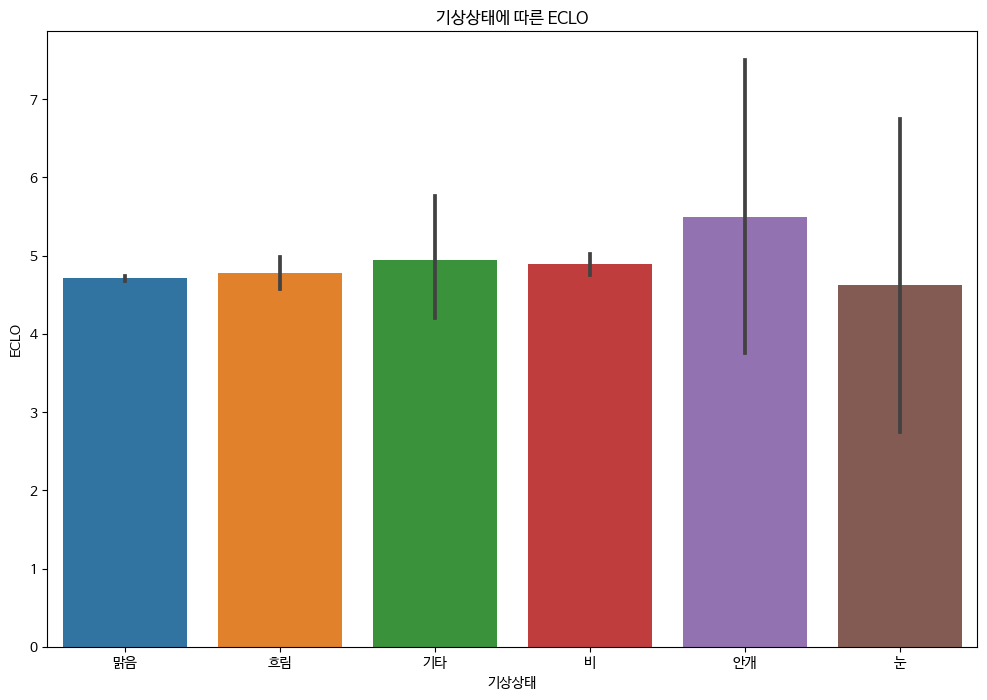

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
plt.rc('font', family='NanumBarunGothic')
# 기상상태에 따른 ECLO 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='기상상태', y='ECLO', data=train_data)
plt.title('기상상태에 따른 ECLO')
plt.show()


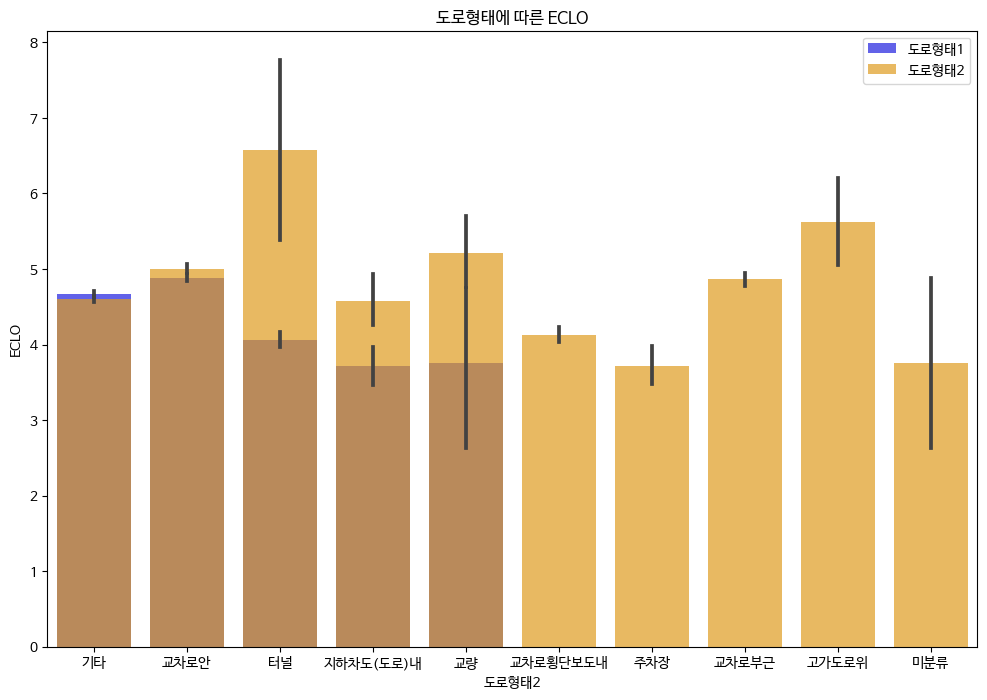

In [ ]:
# 도로형태에 따른 ECLO 사고 발생 비율 시각화
plt.figure(figsize=(12, 8))

# 도로 유형 1에 대한 사고율 플롯
sns.barplot(x='도로형태1', y='ECLO', data=train_data, color='blue', alpha=0.7, label='도로형태1')

# 도로 유형 2에 대한 사고율 플롯
sns.barplot(x='도로형태2', y='ECLO', data=train_data, color='orange', alpha=0.7, label='도로형태2')

plt.title('도로형태에 따른 ECLO')
plt.legend()
plt.show()


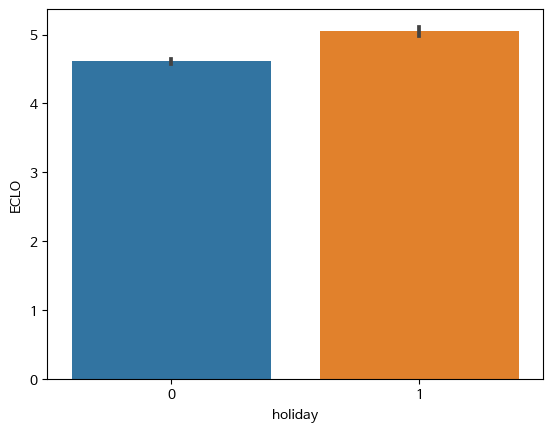

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 휴일에 따른 ECLO 사고 발생 비율 시각화
sns.barplot(data=train_data, x='holiday', y='ECLO')
plt.show() # 1 : 휴일, 0 : 아닌경우

In [ ]:
from scipy import stats

# 샤피로-윌크 검정
stat, p_value = stats.shapiro(train_data['ECLO'])
print(f"Shapiro-Wilk test: Statistic={stat}, p-value={p_value}")

Shapiro-Wilk test: Statistic=0.7156965136528015, p-value=0.0


In [ ]:
# 정규분포를 따르지 않으므로 비모수 검정방법인 맨 휘트니 검정 사용
from scipy.stats import mannwhitneyu

# 데이터 준비
holiday_eclo = train_data[train_data['holiday'] == 1]['ECLO']
non_holiday_eclo = train_data[train_data['holiday'] == 0]['ECLO']

# Mann-Whitney U 검정
u_stat, p_value_u = mannwhitneyu(holiday_eclo, non_holiday_eclo)

# 결과 출력
print(f"Mann-Whitney U 검정 결과 - U-statistic: {u_stat}, p-value: {p_value_u}")
# p-value가 작으므로 휴일여부에 따라 ECLO가 차이가 있음을 의미->앞으로 휴일엔 교통통제 강화하는게 좋을것이라 생각됨

Mann-Whitney U 검정 결과 - U-statistic: 163697654.0, p-value: 5.416542165527167e-24


In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.1 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
# 추출된 문자열 변수 확인
display(categorical_features)

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2', 'season']

,요일,기상상태,노면상태,사고유형,도시,구,동,사고발생횟수,도로형태1,도로형태2,보안등 설치개수,CCTV설치대수,보호구역,급지구분_1,급지구분_2,급지구분_3,단속구분_1,단속구분_2,단속구분_4,단속구분_99,year,month,day,hour,day_of_week,holiday,season
0,4.627926,4.712888,4.712878,3.817650,4.726704,4.541610,4.282449,131,4.671841,4.599599,391.0,13.000000,2.000000,11.0000,0.000000,0.000000,0.0,1.0,4.0,0.0,2019,1,1,0,1,1,4.659111
1,4.627926,4.779150,4.712878,3.817650,4.726704,4.618441,4.738938,678,4.671841,4.599599,932.0,24.429499,8.129005,0.0000,1.000000,3.000000,1.0,3.0,8.0,0.0,2019,1,1,0,1,1,4.659111
2,4.627926,4.712888,4.712878,3.817650,4.726704,4.727300,4.842715,604,4.671841,4.599599,473.0,0.000000,5.000000,-2.0546,-5.120534,4.521916,2.0,2.0,0.0,0.0,2019,1,1,1,1,1,4.659111
3,4.627926,4.712888,4.712878,4.944597,4.726704,4.687669,4.208920,426,4.671841,4.599599,534.0,32.000000,11.000000,0.0000,9.000000,5.000000,2.0,8.0,0.0,0.0,2019,1,1,2,1,1,4.659111
4,4.627926,4.712888,4.712878,4.944597,4.726704,4.889534,4.549091,825,4.671841,4.599599,2057.0,35.168924,1.552907,0.0000,1.000000,0.000000,2.0,10.0,0.0,0.0,2019,1,1,4,1,1,4.659111


,요일,기상상태,노면상태,사고유형,도시,구,동,사고발생횟수,도로형태1,도로형태2,보안등 설치개수,CCTV설치대수,보호구역,급지구분_1,급지구분_2,급지구분_3,단속구분_1,단속구분_2,단속구분_4,단속구분_99,year,month,day,hour,day_of_week,holiday,season
0,4.920811,4.712888,4.712878,3.817650,4.726704,4.727300,4.881657,338,4.882281,5.006142,700.000000,0.000000,5.000000,-2.948869,-3.067164,6.673836,0.0,4.0,0.0,0.0,2022,1,1,1,5,1,4.659111
1,4.920811,4.712888,4.712878,3.817650,4.726704,4.727300,4.563008,492,4.671841,4.599599,-395.555727,0.000000,10.000000,0.000000,0.000000,2.000000,0.0,7.0,0.0,0.0,2022,1,1,1,5,1,4.659111
2,4.920811,4.712888,4.712878,4.944597,4.726704,4.727300,4.945578,147,4.882281,5.006142,56.999538,0.000000,1.000000,0.244122,0.077985,1.499948,0.0,1.0,0.0,0.0,2022,1,1,4,5,1,4.659111
3,4.920811,4.712888,4.712878,4.944597,4.726704,4.727300,4.438172,372,4.671841,4.599599,214.979598,0.000000,7.000000,0.000000,2.000000,1.000000,2.0,9.0,0.0,0.0,2022,1,1,4,5,1,4.659111
4,4.920811,4.712888,4.712878,4.944597,4.726704,4.618441,4.738938,678,4.882281,5.006142,932.000000,24.429499,8.129005,0.000000,1.000000,3.000000,1.0,3.0,8.0,0.0,2022,1,1,6,5,1,4.659111


In [ ]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super(RMSLELoss, self).__init__()

    def forward(self, predictions, actuals):
        assert len(predictions) == len(actuals), "Predictions and targets must have the same length."

        predictions = torch.clamp(predictions, 0.0)  # 예측값이 음수이면 0으로 조정
        log_diff = torch.log(predictions + 1) - torch.log(actuals + 1)
        return torch.sqrt(torch.mean(log_diff**2))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split

# 훈련 데이터를 PyTorch Tensor로 변환
train_tensor_x = torch.tensor(train_x.values, dtype=torch.float32)
train_tensor_y = torch.tensor(train_y.values, dtype=torch.float32)

# 훈련 및 검증 세트로 분할 (8:2 비율)
train_size = int(0.8 * len(train_tensor_x))
val_size = len(train_tensor_x) - train_size

train_dataset, val_dataset = random_split(
    TensorDataset(train_tensor_x, train_tensor_y),
    [train_size, val_size]
)

# 훈련 및 검증 데이터 로더 설정
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [ ]:
class TrafficAccidentPredictorImproved(nn.Module):
    def __init__(self, input_size, output_size=1):
        super(TrafficAccidentPredictorImproved, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_size)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.3)
        self.mish = nn.Mish()
        self.bn = nn.BatchNorm1d(input_size)
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)


    def forward(self, x):
        x = self.bn(x)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.mish(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.mish(x)
        x = self.dropout1(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.mish(x)
        x = self.dropout2(x)
        x = self.fc4(x)

        return x

In [ ]:
# 랜덤스플릿 버전
from torch.optim import AdamW

# kfold 버전
input_size = len(train_x.columns)
model = TrafficAccidentPredictorImproved(input_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실 함수 및 최적화 알고리즘 정의
criterion = RMSLELoss()
optimizer = AdamW(model.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0001)

# 훈련 중에 손실을 기록할 리스트
train_losses = []
val_losses = []

# 모델 훈련
epochs = 100
early_stopping_patience = 50
lr_reduce_patience = 5

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(tqdm(train_dataloader, desc="Epoch {} Training".format(epoch + 1))):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # 훈련 손실 기록
    train_losses.append(total_train_loss / len(train_dataloader))

    # 검증 손실 기록
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        for val_batch_idx, (val_inputs, val_labels) in enumerate(tqdm(val_dataloader, desc="Epoch {} Validation".format(epoch + 1))):
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels.view(-1, 1))
            total_val_loss += val_loss.item()

        val_losses.append(total_val_loss / len(val_dataloader))

    # 에폭마다 손실 출력
    print(f'Epoch {epoch + 1}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Save model weights
    torch.save(model.state_dict(), "./TrafficAccidentPredictor.pth")

    # 조기 종료 체크
    if epoch > early_stopping_patience and min(val_losses[-early_stopping_patience:]) >= min(val_losses):
        print("Early stopping!")
        break

    # 학습률 감소 체크
    if epoch > lr_reduce_patience and min(val_losses[-lr_reduce_patience:]) >= min(val_losses):
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.8
        print(f"Learning rate reduced to {param_group['lr']}")


Epoch 1 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 1 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.5795, Validation Loss: 0.4359


Epoch 2 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 2 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.4634, Validation Loss: 0.4348


Epoch 3 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 3 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.4630, Validation Loss: 0.4351


Epoch 4 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 4 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.4595, Validation Loss: 0.4348


Epoch 5 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 5 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.4576, Validation Loss: 0.4346


Epoch 6 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 6 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 6, Training Loss: 0.4576, Validation Loss: 0.4347


Epoch 7 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 7 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.4552, Validation Loss: 0.4347
Learning rate reduced to 0.0004


Epoch 8 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 8 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.4541, Validation Loss: 0.4350
Learning rate reduced to 0.00032


Epoch 9 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 9 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.4537, Validation Loss: 0.4344
Learning rate reduced to 0.00025600000000000004


Epoch 10 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 10 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.4534, Validation Loss: 0.4346
Learning rate reduced to 0.00020480000000000004


Epoch 11 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 11 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 11, Training Loss: 0.4542, Validation Loss: 0.4345
Learning rate reduced to 0.00016384000000000006


Epoch 12 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 12 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 12, Training Loss: 0.4527, Validation Loss: 0.4340
Learning rate reduced to 0.00013107200000000006


Epoch 13 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 13 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 13, Training Loss: 0.4537, Validation Loss: 0.4341
Learning rate reduced to 0.00010485760000000006


Epoch 14 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 14 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 14, Training Loss: 0.4525, Validation Loss: 0.4344
Learning rate reduced to 8.388608000000005e-05


Epoch 15 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 15 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 15, Training Loss: 0.4523, Validation Loss: 0.4341
Learning rate reduced to 6.710886400000004e-05


Epoch 16 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 16 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 16, Training Loss: 0.4527, Validation Loss: 0.4342
Learning rate reduced to 5.3687091200000036e-05


Epoch 17 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 17 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 17, Training Loss: 0.4522, Validation Loss: 0.4342
Learning rate reduced to 4.2949672960000034e-05


Epoch 18 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 18 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 18, Training Loss: 0.4517, Validation Loss: 0.4341
Learning rate reduced to 3.435973836800003e-05


Epoch 19 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 19 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 19, Training Loss: 0.4518, Validation Loss: 0.4341
Learning rate reduced to 2.7487790694400027e-05


Epoch 20 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 20 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 20, Training Loss: 0.4512, Validation Loss: 0.4340
Learning rate reduced to 2.1990232555520022e-05


Epoch 21 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 21 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 21, Training Loss: 0.4515, Validation Loss: 0.4342
Learning rate reduced to 1.7592186044416018e-05


Epoch 22 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 22 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 22, Training Loss: 0.4526, Validation Loss: 0.4343
Learning rate reduced to 1.4073748835532815e-05


Epoch 23 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 23 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 23, Training Loss: 0.4516, Validation Loss: 0.4341
Learning rate reduced to 1.1258999068426253e-05


Epoch 24 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 24 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 24, Training Loss: 0.4520, Validation Loss: 0.4343
Learning rate reduced to 9.007199254741003e-06


Epoch 25 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 25 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 25, Training Loss: 0.4516, Validation Loss: 0.4341
Learning rate reduced to 7.205759403792802e-06


Epoch 26 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 26 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 26, Training Loss: 0.4517, Validation Loss: 0.4341
Learning rate reduced to 5.764607523034242e-06


Epoch 27 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 27 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 27, Training Loss: 0.4525, Validation Loss: 0.4341
Learning rate reduced to 4.611686018427394e-06


Epoch 28 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 28 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 28, Training Loss: 0.4513, Validation Loss: 0.4342
Learning rate reduced to 3.6893488147419155e-06


Epoch 29 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 29 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 29, Training Loss: 0.4526, Validation Loss: 0.4342
Learning rate reduced to 2.9514790517935326e-06


Epoch 30 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 30 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 30, Training Loss: 0.4523, Validation Loss: 0.4341
Learning rate reduced to 2.361183241434826e-06


Epoch 31 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 31 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 31, Training Loss: 0.4517, Validation Loss: 0.4341
Learning rate reduced to 1.888946593147861e-06


Epoch 32 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 32 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 32, Training Loss: 0.4523, Validation Loss: 0.4341
Learning rate reduced to 1.511157274518289e-06


Epoch 33 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 33 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 33, Training Loss: 0.4509, Validation Loss: 0.4341
Learning rate reduced to 1.2089258196146312e-06


Epoch 34 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 34 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 34, Training Loss: 0.4522, Validation Loss: 0.4342
Learning rate reduced to 9.67140655691705e-07


Epoch 35 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 35 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 35, Training Loss: 0.4523, Validation Loss: 0.4340
Learning rate reduced to 7.73712524553364e-07


Epoch 36 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 36 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 36, Training Loss: 0.4510, Validation Loss: 0.4342
Learning rate reduced to 6.189700196426912e-07


Epoch 37 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 37 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 37, Training Loss: 0.4518, Validation Loss: 0.4342
Learning rate reduced to 4.95176015714153e-07


Epoch 38 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 38 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 38, Training Loss: 0.4513, Validation Loss: 0.4341
Learning rate reduced to 3.9614081257132243e-07


Epoch 39 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 39 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 39, Training Loss: 0.4515, Validation Loss: 0.4341
Learning rate reduced to 3.1691265005705797e-07


Epoch 40 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 40 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 40, Training Loss: 0.4517, Validation Loss: 0.4341
Learning rate reduced to 2.535301200456464e-07


Epoch 41 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 41 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 41, Training Loss: 0.4509, Validation Loss: 0.4341
Learning rate reduced to 2.0282409603651712e-07


Epoch 42 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 42 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 42, Training Loss: 0.4525, Validation Loss: 0.4343
Learning rate reduced to 1.622592768292137e-07


Epoch 43 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 43 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 43, Training Loss: 0.4525, Validation Loss: 0.4342
Learning rate reduced to 1.2980742146337097e-07


Epoch 44 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 44 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 44, Training Loss: 0.4519, Validation Loss: 0.4341
Learning rate reduced to 1.0384593717069678e-07


Epoch 45 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 45 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 45, Training Loss: 0.4520, Validation Loss: 0.4341
Learning rate reduced to 8.307674973655743e-08


Epoch 46 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 46 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 46, Training Loss: 0.4518, Validation Loss: 0.4341
Learning rate reduced to 6.646139978924594e-08


Epoch 47 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 47 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 47, Training Loss: 0.4517, Validation Loss: 0.4342
Learning rate reduced to 5.316911983139676e-08


Epoch 48 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 48 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 48, Training Loss: 0.4512, Validation Loss: 0.4344
Learning rate reduced to 4.2535295865117407e-08


Epoch 49 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 49 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 49, Training Loss: 0.4517, Validation Loss: 0.4341
Learning rate reduced to 3.4028236692093927e-08


Epoch 50 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 50 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 50, Training Loss: 0.4522, Validation Loss: 0.4341
Learning rate reduced to 2.7222589353675143e-08


Epoch 51 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 51 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 51, Training Loss: 0.4514, Validation Loss: 0.4341
Learning rate reduced to 2.1778071482940114e-08


Epoch 52 Training:   0%|          | 0/496 [00:00<?, ?it/s]

Epoch 52 Validation:   0%|          | 0/124 [00:00<?, ?it/s]

Epoch 52, Training Loss: 0.4514, Validation Loss: 0.4341
Early stopping!


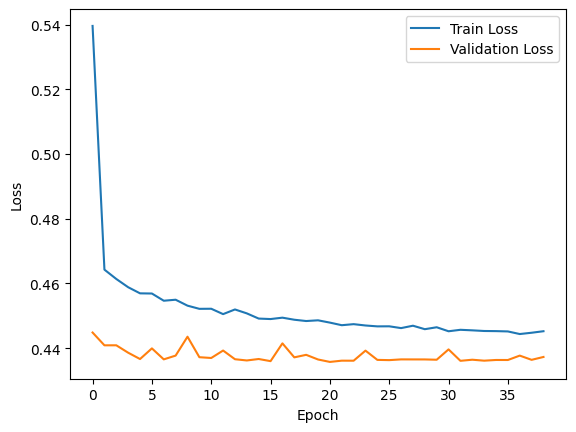

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# 테스트 데이터로 예측
with torch.no_grad():
    model.eval()
    test_inputs = torch.tensor(test_x.values, dtype=torch.float32)
    # test_inputs를 모델이 사용하는 디바이스로 옮기기
    test_inputs = test_inputs.to(device)
    predictions = model(test_inputs)

# 예측 결과 출력
print(predictions)

tensor([[3.9342],
        [3.7397],
        [4.7957],
        ...,
        [4.8141],
        [4.6666],
        [4.5478]], device='cuda:0')


In [ ]:
predictions[:10]

tensor([[3.8480],
        [3.5052],
        [4.7862],
        [4.1644],
        [4.4213],
        [3.7834],
        [4.2468],
        [3.6595],
        [4.0832],
        [4.3413]], device='cuda:0')

In [ ]:
# CUDA(GPU)에서 CPU로 텐서 옮기기
predictions_array = predictions.cpu().numpy().flatten()
sample_submission["ECLO"] = predictions_array
sample_submission.to_csv('/content/drive/MyDrive/교통사고/result/submission_토치_random.csv',index=False)